In [5]:
import pandas as pd 
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
df=pd.read_csv("blocstak_data.csv")

There are **4521** datapoints in this dataset. The dataset is highly imbalanced with **y**'s ratio of unique values being **0.88: 0.12**

In [7]:
print(f"LENGTH OF DATASET: {len(df)}")
print((df.y.value_counts()/len(df)))


LENGTH OF DATASET: 4521
no     0.88476
yes    0.11524
Name: y, dtype: float64


In [8]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no


In [9]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


From the data, some forms of cleaning that seem necessary are:
- The **day** column isnt quite necessary due to the monthly information being readily available.
- The **month** column would be better utilized within a ordinal form of values instead of plain strings.
- The **duration** column needs to be normalized to minutes from seconds due to scale of durations. 
- The **y** variables are better of renamed to **result** for analysis. We can keep a seperate **y** column for binary values.

In [10]:
# Drop days
df.drop(columns=['day'],inplace=True)
# Normalize duration from aseco0nds to minutes
df['duration'] = df['duration'].apply(lambda n:n/60).round(2)
# Add binarized column
df['result']=df['y'].copy()
df['y'] = df['y'].apply(lambda x: 0 if x == 'no' else 1)
# Create dictionary of months to map to ordinal values
month_list=list(enumerate(calendar.month_name))[1:]
month_dict={key.lower()[:3]:value for value,key in month_list}
# Map month strings to ordinal values
df['month']=df.month.apply(lambda x:month_dict[x])


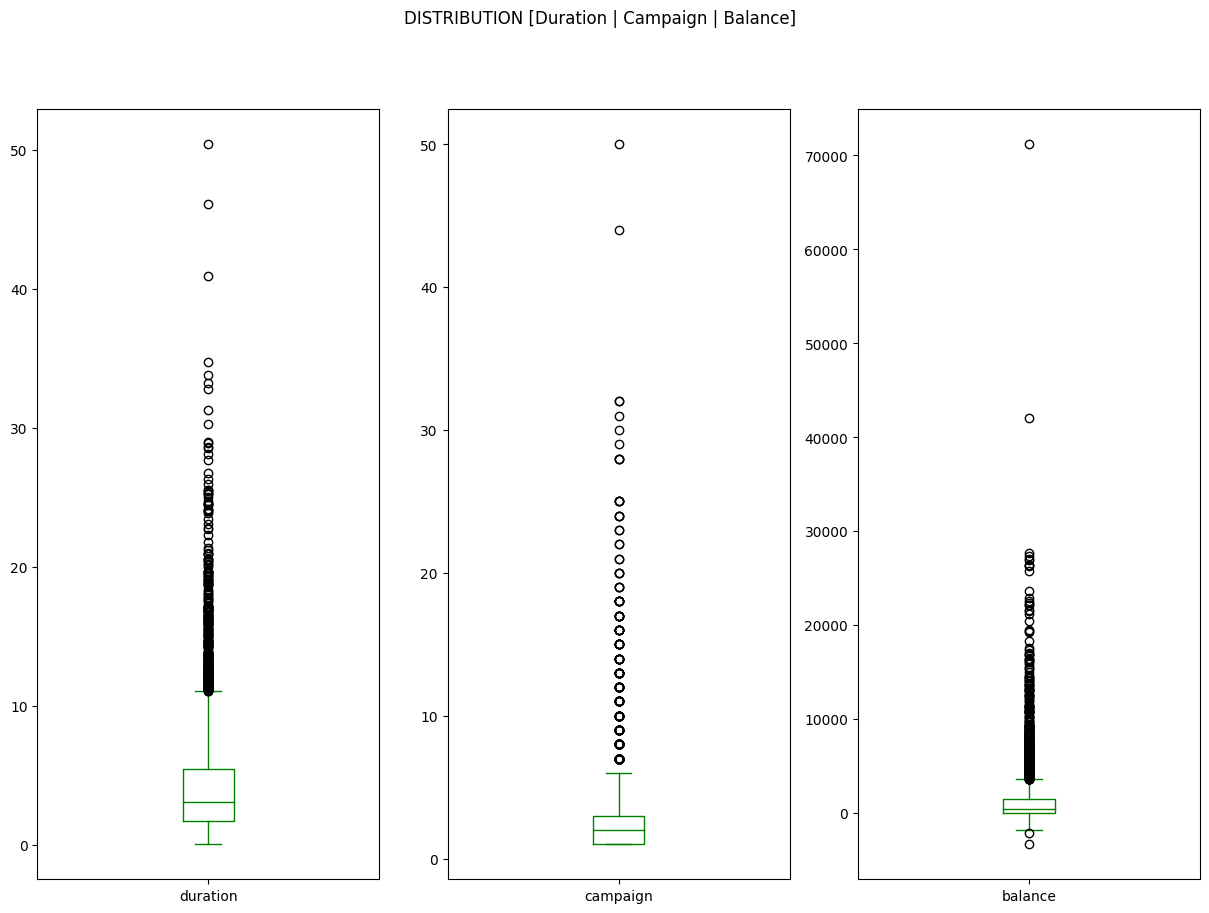

,min,std,mean,median,outlier_count,Q1,Q3,IQR,<1.5*IQR,>1.5*IQR
duration,0.07,4.330971,4.399367,3.08,330.0,1.73,5.48,3.75,-3.895,11.105
campaign,1.00,3.109807,2.793630,2.00,318.0,1.00,3.00,2.00,-2.000,6.000
balance,-3313.00,3009.638142,1422.657819,444.00,506.0,69.00,1480.00,1411.00,-2047.500,3596.500


In [11]:
def get_q_dict(column:pd.Series):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    return {'Q1':Q1,'Q3':Q3,'IQR':IQR}


def outlier_count(column:pd.Series):
    qdict=get_q_dict(column)
    Q1,Q3,IQR=qdict['Q1'],qdict['Q3'],qdict['IQR']
    threshold = 1.5
    outliers = (column < Q1 - threshold * IQR) | (column > Q3 + threshold * IQR)
    return outliers.sum()


#Aggregating data for "Duration", "Campaign", "Balance" columns in the dataset
durcampbal=df[['duration','campaign','balance']].agg(func=['min','std','mean','median',outlier_count],axis='rows').T
q_dict_list=[get_q_dict(df[col]) for col in durcampbal.index]
durcampbal['Q1']=[i['Q1'] for i in q_dict_list]
durcampbal['Q3']=[i['Q3'] for i in q_dict_list]
durcampbal['IQR']=[i['IQR'] for i in q_dict_list]
durcampbal['<1.5*IQR']=durcampbal['Q1']-1.5*durcampbal['IQR']
durcampbal['>1.5*IQR']=durcampbal['Q3']+1.5*durcampbal['IQR']

#Visualizing boxplots and outliers based on observed data
duration_distance_plot = df[['duration','campaign','balance']].plot(kind = 'box', color= 'green',
                                                      figsize = (15,10),
                                                      subplots = True, layout = (1,3),
                                                      sharex = False, sharey = False,
                                                      title='DISTRIBUTION [Duration | Campaign | Balance]')
plt.show()

durcampbal

- **Distribution of Duration**: Observations from table and boxplot indicates the duration of contact had a median of 3 minutes, along with a first quartile of 1.73 minutes with a third quartile of 5.3 minutes spanning a 3.7 minute Inter Quartile Range. The relative left skew in the distribution shows that most calls were on the shorter end with considerable amount of outliers ranging from 11 to 40 minutes. These outliers seem to be key in hunting for marketing leads.
- **Distribution of Campaign**: 25% of the customers were contacted by the bank for the first time, while approximately half of them were contacted for the second time. Most clients were contacted only thrice, however there is a even distribution of outlieres ranging from 5 times to approximately 33 times along with a select few ranging to be as high as 45 to 50 times.
- **Distribution of Balance**: Balance seems to show the highest amount of outliers and is the most left skewed of the three distributions we have seens so far, with values even extending to negatives ranging of considerable magnitude. (Funnily enough, this also goes to represent how the rich keep eating the poor hehe). The standard deviation and high interquartile range represents the high population of outliers as seen in the boxplot. Also, it can be seen that there is probably just a single or two outliers in the 40 thousands' range.
- The extreme outliers on all three distributions need to be dropped for better probabilistic modelling.

In [12]:
extreme_outlier_rows=df[(df.duration>40)|(df.balance>30000)|(df.campaign>40)]
df.drop(extreme_outlier_rows.index,inplace=True)

Age details: 
count    4514.000000
mean       41.161276
std        10.575681
min        19.000000
25%        33.000000
50%        39.000000
75%        49.000000
max        87.000000
Name: age, dtype: float64


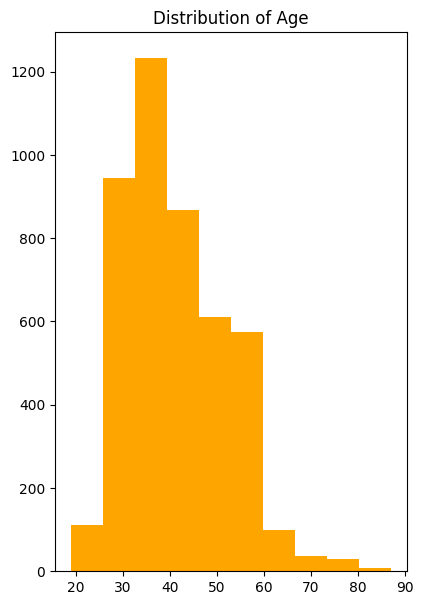

In [14]:
plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
plt.hist(df.age,color='orange')
plt.title("Distribution of Age")

print(f"Age details: \n{df['age'].describe()}")


- **Distribution of Age**: Majority of clients contacted by bank seem of in their 30s or 40s (The interquartile range of percentiles range from 33 to 48 year olds). Other than this, the distribution is fairly normal.

In [15]:
df['age_buck']=pd.cut(df.age,bins=[df.age.min(),30,40,50,60,df.age.max()],labels=["=<30","30-40","40-50","50-60",">=60"],right=True)

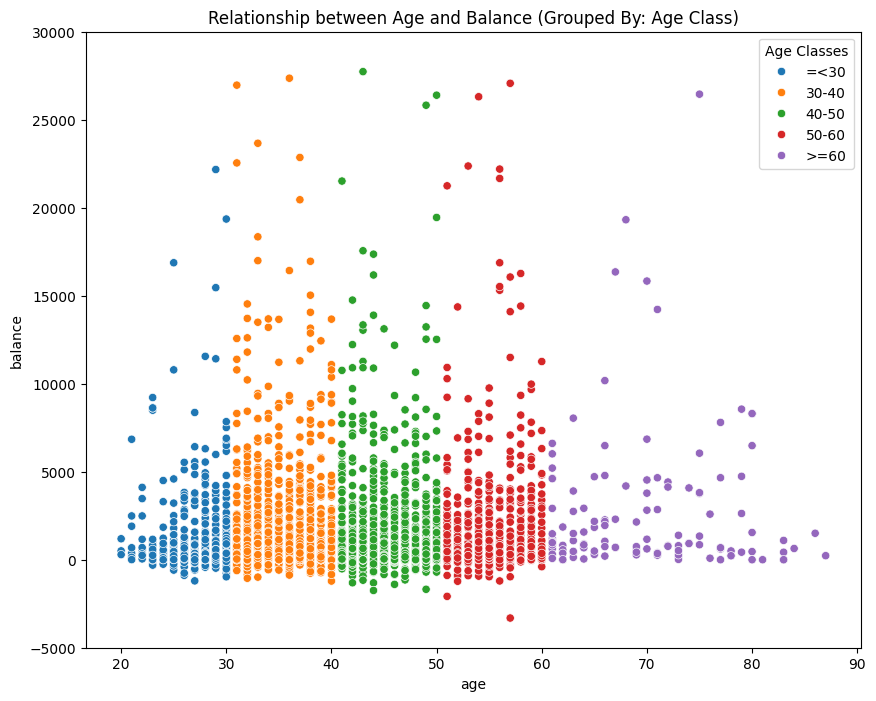

In [16]:
import numpy as np
#Capping our balance to a max of 30000 for extreme outliers
plt.figure(figsize=(10,8))
plt.ylim(-5000,30000)
sns.scatterplot(x='age',y='balance',data=df,hue='age_buck')
plt.title('Relationship between Age and Balance (Grouped By: Age Class)')
plt.legend(title='Age Classes')




From the above diagram, it is safe to conclude that there isnt any notable relationship between **Age** and **Balance** of customers in terms of specific age groups. However, it can be noted that people at 60 and above tend to have lesser balance than younger people, also, people at after 60, tend to have very low negative balances. This could be due to planned funding of expenses that people make due to retirement.

Text(0.5, 1.0, 'Feature Correlation Heatmap')

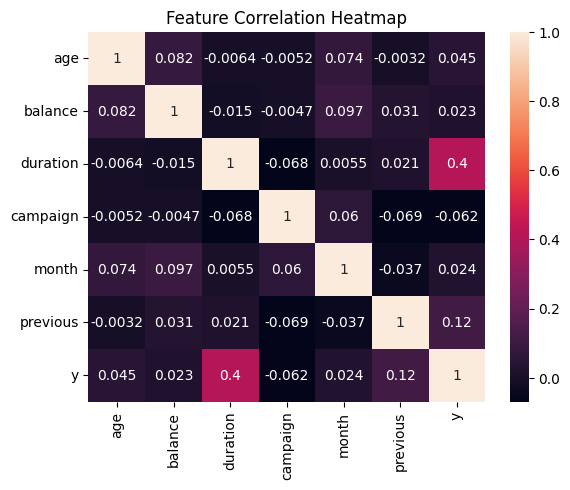

In [47]:

feature_correlation= df[['age','balance','duration','campaign','month','previous','y']].corr()
corr_map=sns.heatmap(feature_correlation,annot=True,)
plt.title('Feature Correlation Heatmap')

In order for more indepth analysis we need to look at how each of our dataset features correlate with all the other features. As we can see in our correlationmap, there is strong correlation among **marketting result**, **call duration** and **Campaign**. This goes to show that marketting success is highly dependant on customer interactions. We can also see considerable correlation between **marketting result** and **age** and between **age** and **balance** in turn. As we can see, most of the higher values of correlation with marketting results pertain to dataset features that relate to customer characterisitcs (E.g: **age**, **balance**, **duration**,). Thus it would be beneficial to look at aggregate cluster based results on categorical customer based features inorder for more insight. 

## Relationship between Different Features and Age Groups

One of the basic and most prominent customer characteristic feature in our dataset is **Age**. Let us visualize customer sensitivity of each age group to our marketting campaigns. **(Conversion/Interaction Rate)**

### Balance
As observed in correlation map, there is strong correlation between:
- **age** and **conversion**. 
- **balance** and **age**. 

This goes to show that binning our **balances** to certain levels may show some insights between age_group sensitivity towards marketting campaign when paired with pertaining balances of age groups.

In [ ]:
# balance_group=(df.groupby(['age_buck','balance_buck'],as_index=False).y.sum())
# balance_group['Contacted']=df.groupby(['age_buck','balance_buck'],as_index=False).campaign.sum().campaign  
# balance_group1=balance_group.copy(deep=True)
# balance_group1.pop('Contacted')    
# age_interaction=balance_group.groupby('age_buck',as_index=False).Contacted.sum()    
# for age in age_interaction.age_buck.unique():
#     balance_group1[balance_group1.age_buck==age].y=balance_group1[balance_group1.age_buck==age].y*100/balance_group[balance_group.age_buck==age].Contacted.sum()
#     new_entry=pd.DataFrame({
#         'age_buck':age,
#         'balance_buck':'Total Interactions',
#         'y':(balance_group[balance_group.age_buck==age].Contacted.sum()/balance_group.Contacted.sum())*100
#     },index=[0])
#     balance_group1=pd.concat([balance_group1,new_entry],ignore_index=True)
# balance_group1.sort_values('age_buck')

In [275]:
int(age_interaction.loc[age_interaction['age_buck']=='=<30'].Contacted)

1743

Text(0.5, 1.0, 'Conversion based on Different Age and Balance Groups')

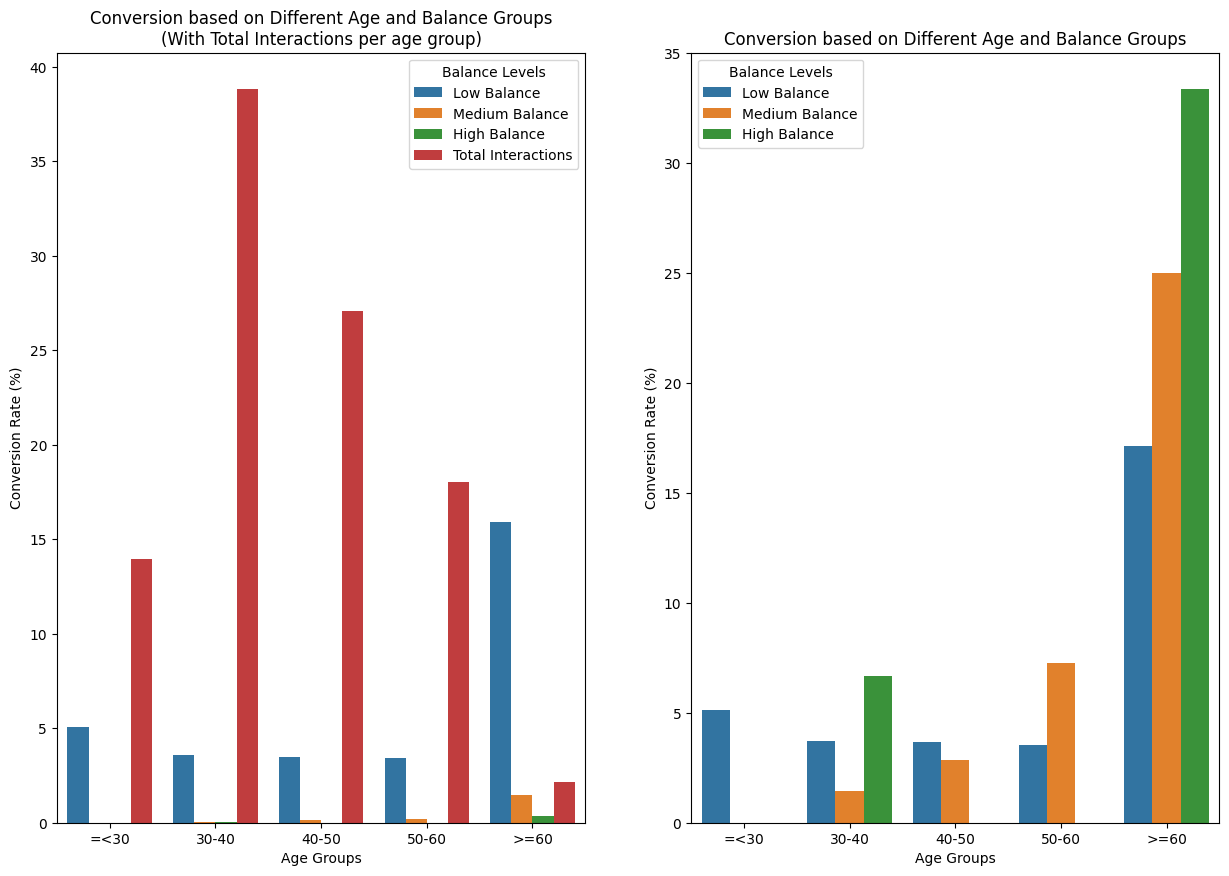

In [384]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
balance_group=(df.groupby(['age_buck','balance_buck'],as_index=False).y.sum())
balance_group['Contacted']=df.groupby(['age_buck','balance_buck'],as_index=False).campaign.sum().campaign  
balance_group1=balance_group.copy(deep=True)
balance_group1.pop('Contacted')    
age_interaction=balance_group.groupby('age_buck',as_index=False).Contacted.sum() 
interactions_df=pd.DataFrame([])
for age in age_interaction.age_buck.unique():
    # print(age)
    # print(balance_group1[balance_group1.age_buck==age].y/int(age_interaction[age_interaction.age_buck==age].Contacted)*100)
    balance_group1.loc[(balance_group1.age_buck==age),'y']=(balance_group1[balance_group1.age_buck==age].y/int(age_interaction[age_interaction.age_buck==age].Contacted))*100
    new_entry=pd.DataFrame({
        'age_buck':age,
        'balance_buck':'Total Interactions',
        'y':float((age_interaction[age_interaction['age_buck']==age].Contacted/age_interaction.Contacted.sum())*100)
    },index=[0])
    interactions_df=pd.concat([interactions_df,new_entry],ignore_index=True)
balance_group1=pd.concat([balance_group1,interactions_df],ignore_index=True)
balance_group1.sort_values('age_buck')

sns.barplot(x='age_buck',y='y',hue='balance_buck',data=balance_group1)
plt.legend(title='Balance Levels')
plt.xlabel("Age Groups")
plt.ylabel("Conversion Rate (%)")
plt.title("Conversion based on Different Age and Balance Groups\n(With Total Interactions per age group)")

plt.subplot(1,2,2)
df['balance_buck']=pd.cut(df.balance,bins=3,labels=('Low Balance','Medium Balance','High Balance'))
balance_group=df.balance_buck.value_counts()
balance_group=(df.groupby(['age_buck','balance_buck'],as_index=False).y.sum())
balance_group['Contacted']=df.groupby(['age_buck','balance_buck'],as_index=False).campaign.sum().campaign
age_interaction=balance_group.groupby('age_buck',as_index=False).Contacted.sum()    


balance_group.y=(balance_group.y/balance_group['Contacted'])*100
balance_group.sort_values(['age_buck','balance_buck'],ascending=[True,False],inplace=True)
sns.barplot(x='age_buck',y='y',hue='balance_buck',data=balance_group)
plt.legend(title='Balance Levels')
plt.xlabel("Age Groups")
plt.ylabel("Conversion Rate (%)")
plt.title("Conversion based on Different Age and Balance Groups")

**Insight:**
- From the above figure we can see that the **youngest** and **oldest age groups** show the highest responsiveness to marketting campaigns given the **Total Number of Interactions per group**
- It can also be noted that all **Age Groups** with **lower levels of balances** tended to be more responsiveness to marketting campaigns as compared to **Age Groups** of **other balances**
- **Age Groups** of *'30-40'* tend to be more responsive towards marketting campaign when **Balance Level** is high. This pertains to the reducing lack of knowledge in investment of growing funds/capital as consumers grow in their respective careers.
- In **Age Groups** of *'40-50'* and *'50-60'*, higher comparitive responsiveness of **Balance Level** moved from *'Low'* to *'High'* as compared to other  **balance levels** because the consumers are slowly becoming more aware of different forms of short sized investments with age and development in career, thus people with lower levels of **Balance** at the age of *'50-60'* shift towards other forms of investments as compared to people with lower levels of **Balance** at the age of *'40-50'*.

,age_buck,Converted,Interacted
=<30,628,14.01,13.92
30-40,1798,9.84,39.87
40-50,1159,10.53,25.70
50-60,798,10.28,17.69
>=60,127,37.80,2.82


<Figure size 900x900 with 0 Axes>

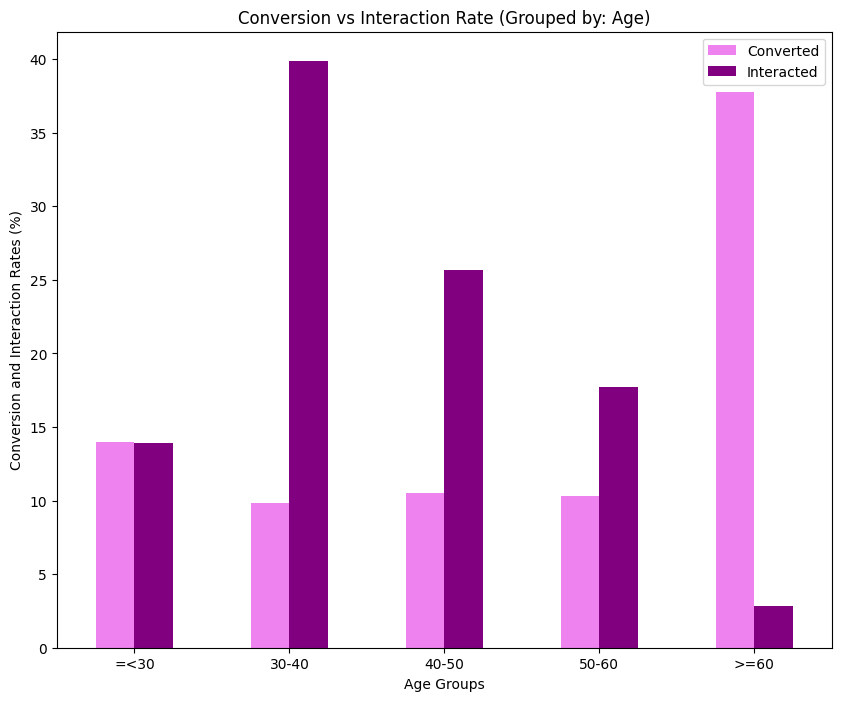

In [385]:
age = pd.DataFrame(df['age_buck'].value_counts())

result_age_group=df.groupby(['age_buck','result']).result.count()
subscription_idx=[i for i  in result_age_group.index.tolist() if i[1]=='yes']


age.sort_index(inplace=True)
age['Converted']=((result_age_group[subscription_idx].to_numpy()/age['age_buck'])*100).round(2)
age['Interacted']=((age['age_buck']/age['age_buck'].sum())*100).round(2)
plt.figure(figsize=(9,9))
age[['Converted','Interacted']].plot(kind='bar',figsize=(10,8),color=('violet','purple'))

plt.xlabel("Age Groups")
plt.ylabel('Conversion and Interaction Rates (%)')
plt.xticks(rotation='horizontal')
plt.title('Conversion vs Interaction Rate (Grouped by: Age)')
age

**Insight: Wrong age groups are being focused on for marketting deposit based schemes. Focus should be more on the youngest and oldest age groups**\
\
From the above chart we can clearly see that age groups within the range of 30-60 years of age, are much less sensitive to marketting efforts by bank as compared to those younger that 30 years of age and those older than 60 years of age.
- It seems that old people are most sensitive to deposit based marketting efforts by bank due to probable availability of wealth accumulated through out the years. 
- Younger people's attraction to monthly interests on deposits seems to stem from the lack of proper knowledge on investment schemes and may seem as a lucrative option for liquidity to the age group in general. The sensitivity of younger age groups towards marketting interactions thus show that there might be **occupational dependencies** on a customer's preference of marketting campaigns due age being a general indicator of a person's position in his or her career. 

Text(0.5, 1.0, 'Job Position Sensitivity toward Marketting Campaign')

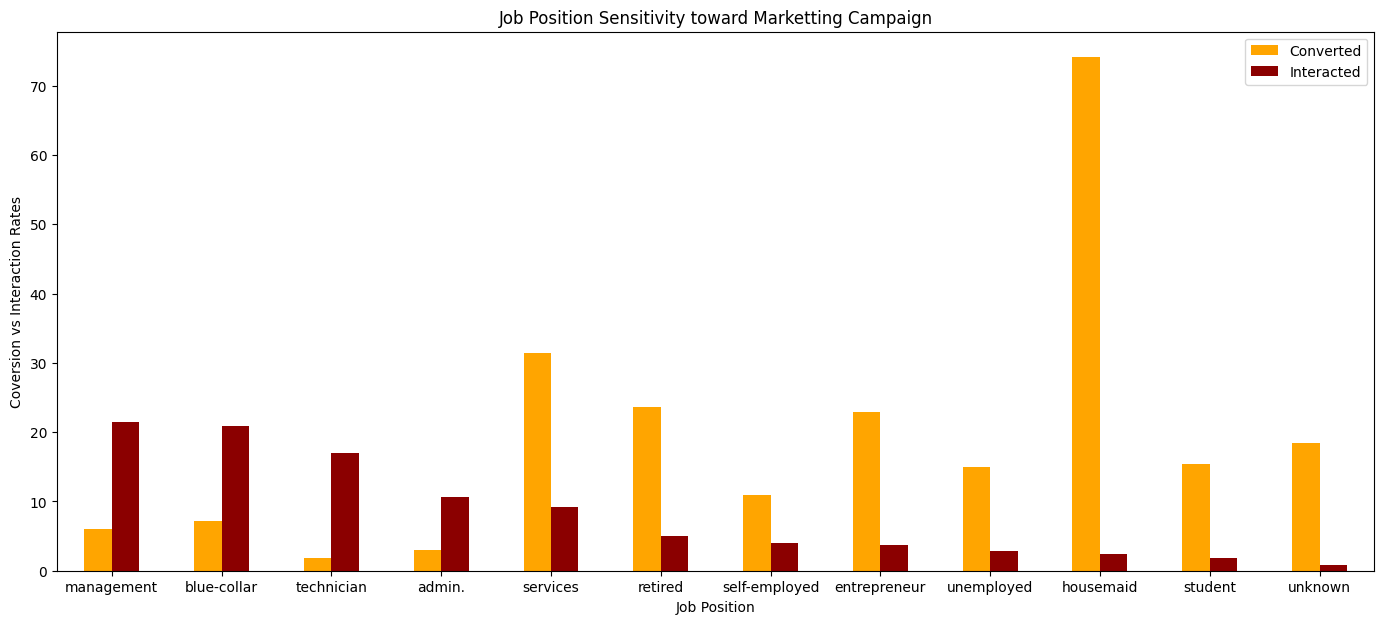

In [127]:
job=pd.DataFrame(df.job.value_counts())
job['Converted']=(df.groupby(['job','result']).y.sum()[df.groupby(['job','result']).y.sum()>0].to_numpy()/job['job'])*100
job["Interacted"]=(job["job"]/job['job'].sum())*100

job[['Converted','Interacted']].plot(kind='bar',figsize=(17,7),color=('orange','darkred'))
plt.xticks(rotation='horizontal')
plt.ylabel('Coversion vs Interaction Rates')
plt.xlabel('Job Position')
plt.title('Job Position Sensitivity towards Marketting Campaign')

**Insight: Customers from the wrong job classes are being focused on by campaign**
- As inferred from our previous Age based Conversion Diagrams, there is high dependency between **Customer Conversion Rates** and **Job Positions**, and the bank is focusing on customers from ther wrong job positions.
- For example: **Job Positions** like management, blue-collar, technician, and admin are all getting comparitively higher focus from marketting campaign than the other job positions even though all the others seem to be more positively sensitive towards the campaign. The most suprising factor among which is that **housemaids** seem to be the most sensitive towards marketting campaigns. Thus our campaigns and services should be tailored in a way to take advantage of this in forms of **micro investment/deposit instruments** and their promotions. 

## Call Duration & Campaign

As in most campaigns,one of the key factors to determine marketting success is conversion rate compared to interactions. So let us look at the relationship between marketting success is mapped to Call Duration of Last Telemarketting Call by bank to customer and the number of times the customer was contacted. 

/home/mehedi/anaconda3/envs/hf_env/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(20, 45, 'Greater Subscription rate when no. of calls <5')

<Figure size 800x1500 with 0 Axes>

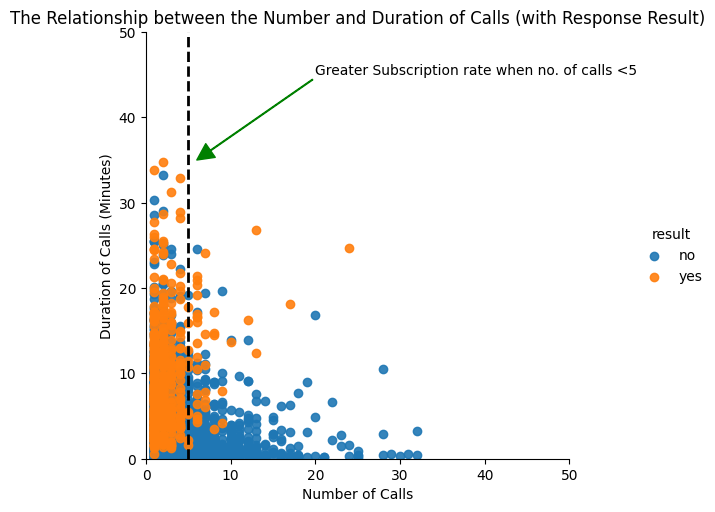

In [36]:
plt.figure(figsize=(8,15))
sns.lmplot(x='campaign',y='duration',data=df,hue='result',fit_reg=False,height=5,scatter_kws={'alpha':0.9})

plt.axis([0,50,0,50])
plt.ylabel('Duration of Calls (Minutes)')
plt.xlabel('Number of Calls')
plt.title('The Relationship between the Number and Duration of Calls (with Response Result)')


plt.axvline(x=5, linewidth=2, color="black", linestyle='--')
plt.annotate("Greater Subscription rate when no. of calls <5", xytext=(20,45), arrowprops=dict(color='green',width=0.5),xy=(6,35))

According to this scatter plot, the datapoints form two clusters in which most datapoints with larger number of contact instances tend to have coversations of lower durations that usually ends up with negative client response. Whereas, most positive responses tend to come from clients who have been contacted fewer times, but have had long, engaging converstions each time he or she was contacted. Clients seem to be more likely to reject the deposit scheme unless conversation is long and engaging or number of times contacted is less than 5.
This suggests that banks should refrain from calling a client more than 5 times as well as making telemarketting conversations more engaging.

/home/mehedi/anaconda3/envs/hf_env/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x1500 with 0 Axes>

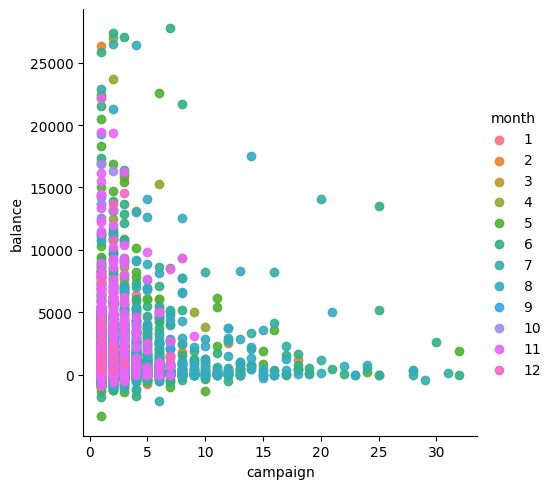

In [41]:
plt.figure(figsize=(8,15))
sns.lmplot(x='campaign',y='balance',data=df,hue='month',fit_reg=False,height=5,scatter_kws={'alpha':0.9})

In [ ]:
df['balance']

0       1787
1       4789
2       1350
3       1476
4          0
        ... 
4516    -333
4517   -3313
4518     295
4519    1137
4520    1136
Name: balance, Length: 4521, dtype: int64

In [26]:
df

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y,result,age_buck
0,30,unemployed,married,primary,no,1787,no,no,cellular,10,1.32,1,-1,0,unknown,0,no,=<30
1,33,services,married,secondary,no,4789,yes,yes,cellular,5,3.67,1,339,4,failure,0,no,30-40
2,35,management,single,tertiary,no,1350,yes,no,cellular,4,3.08,1,330,1,failure,0,no,30-40
3,30,management,married,tertiary,no,1476,yes,yes,unknown,6,3.32,4,-1,0,unknown,0,no,=<30
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,3.77,1,-1,0,unknown,0,no,50-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,7,5.48,5,-1,0,unknown,0,no,30-40
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,5,2.55,1,-1,0,unknown,0,no,50-60
4518,57,technician,married,secondary,no,295,no,no,cellular,8,2.52,11,-1,0,unknown,0,no,50-60
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,2,2.15,4,211,3,other,0,no,=<30


In [ ]:
df[['age','balance','duration','campaign','month','previous','y']]